In [1]:
# 03_uncertainty.ipynb - Experiment Definition

"""
PHASE 3: UNCERTAINTY QUANTIFICATION
-----------------------------------
Hypothesis 1 (Alignment):
    High uncertainty should correlate with high reconstruction error.
    Metric: Spearman Rank Correlation > 0.

Hypothesis 2 (OOD Detection):
    Uncertainty should be significantly higher on 'Extreme' noise (0.5)
    compared to 'Standard' noise (0.1).

Hypothesis 3 (Safety/Rejection):
    Referring (removing) the top X% most uncertain samples should
    monotonically decrease the MSE of the remaining samples.

Constraint:
    We will NOT modify the original `models/backbone.py`.
    We will create a specific subclass for MC Dropout to preserve the baseline.
"""
print("✅ Hypotheses locked.")


from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')


✅ Hypotheses locked.
Mounted at /content/drive


In [2]:
%%writefile /content/drive/MyDrive/MIG_Uncertainty_Project/utils/metrics.py
import torch
import numpy as np
from scipy.stats import spearmanr

def compute_uncertainty_metrics(preds, targets, uncertainty):
    """
    Computes rigorous uncertainty metrics.

    Args:
        preds: (Batch, Length) - Mean prediction
        targets: (Batch, Length) - Ground truth
        uncertainty: (Batch, Length) - Predictive variance

    Returns:
        dict: MSE, Mean Uncertainty, Spearman Correlation
    """
    # 1. Reconstruction Error (MSE per sample)
    # Shape: (Batch, Length) -> (Batch,)
    mse_per_sample = torch.mean((preds - targets)**2, dim=1)

    # 2. Mean Uncertainty per sample
    # Shape: (Batch, Length) -> (Batch,)
    unc_per_sample = torch.mean(uncertainty, dim=1)

    # 3. Spearman Correlation (Rank-based, robust to non-linearity)
    # We compare the rank of Error vs Rank of Uncertainty
    mse_np = mse_per_sample.detach().cpu().numpy()
    unc_np = unc_per_sample.detach().cpu().numpy()

    if len(mse_np) > 1:
        # spearmanr returns (correlation, p_value)
        corr, _ = spearmanr(mse_np, unc_np)
    else:
        corr = 0.0

    return {
        "mse": mse_per_sample.mean().item(),
        "mean_uncertainty": unc_per_sample.mean().item(),
        "spearman_corr": corr,
        "mse_per_sample": mse_per_sample, # Return tensors for plotting
        "unc_per_sample": unc_per_sample
    }

def compute_rejection_curve(errors, uncertainties, steps=20):
    """
    Simulates 'referring' uncertain samples to a human.
    As we remove uncertain samples, error should drop.
    """
    errors = np.array(errors)
    uncertainties = np.array(uncertainties)

    # Sort by uncertainty (High to Low)
    indices = np.argsort(-uncertainties)
    sorted_errors = errors[indices]

    metrics = {"retention": [], "rmse": []}

    n_samples = len(errors)

    for i in range(steps):
        # Keep top k% (Retention)
        # retention = 1.0 means keep 100%
        # retention = 0.1 means keep 10% (lowest uncertainty)
        retention_rate = (steps - i) / steps
        n_keep = int(n_samples * retention_rate)

        if n_keep < 1: break

        # The 'kept' samples are at the END of the sorted list (Lowest uncertainty)
        kept_errors = sorted_errors[n_samples - n_keep : ]
        rmse = np.sqrt(np.mean(kept_errors))

        metrics["retention"].append(retention_rate)
        metrics["rmse"].append(rmse)

    return metrics

Overwriting /content/drive/MyDrive/MIG_Uncertainty_Project/utils/metrics.py


In [3]:
%%writefile /content/drive/MyDrive/MIG_Uncertainty_Project/models/backbone_dropout.py
import torch
import torch.nn as nn

class ConvAutoencoderMCDropout(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(ConvAutoencoderMCDropout, self).__init__()

        # --- ENCODER ---
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Dropout(p=dropout_rate), # Explicit Dropout
            nn.MaxPool1d(2, stride=2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Dropout(p=dropout_rate), # Explicit Dropout
            nn.MaxPool1d(2, stride=2),
        )

        # --- DECODER ---
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.Dropout(p=dropout_rate), # Explicit Dropout

            nn.ConvTranspose1d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 1. Shape Safety Check (Restored)
        original_len = x.shape[-1]

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # 2. Shape Assertion
        assert decoded.shape[-1] == original_len, \
            f"Shape Mismatch! Input: {original_len}, Output: {decoded.shape[-1]}"

        return decoded

Overwriting /content/drive/MyDrive/MIG_Uncertainty_Project/models/backbone_dropout.py


In [4]:
%%writefile /content/drive/MyDrive/MIG_Uncertainty_Project/models/uncertainty_wrapper.py
import torch
import torch.nn as nn

class MCDropoutWrapper(nn.Module):
    def __init__(self, model, n_passes=20):
        super().__init__()
        self.model = model
        self.n_passes = n_passes

    def forward(self, x):
        # Crucial: MC Dropout requires dropout layers to be active.
        # However, we must be careful not to affect BatchNorm stats (if we had them).
        # Since our backbone ONLY has Dropout and Conv, .train() is 'safe enough'
        # BUT we must acknowledge this design decision.
        self.model.train()

        outputs = []
        for _ in range(self.n_passes):
            with torch.no_grad():
                outputs.append(self.model(x))

        outputs = torch.stack(outputs) # (T, B, C, L)

        # Mean prediction
        mean_pred = outputs.mean(dim=0)

        # Predictive Variance (Uncertainty)
        # Squeeze channel dim: (B, 1, L) -> (B, L)
        variance = outputs.var(dim=0).squeeze(1)

        return mean_pred, variance

Overwriting /content/drive/MyDrive/MIG_Uncertainty_Project/models/uncertainty_wrapper.py


In [5]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import random
import numpy as np
import json

# 1. Project Setup
import sys
PROJECT_ROOT = "/content/drive/MyDrive/MIG_Uncertainty_Project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
# Imports
from models.backbone_dropout import ConvAutoencoderMCDropout
from utils.data_loader import NoisyECGDataset

# --- 1. STRICT SEEDING (FIX 1) ---
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(SEED)

# Generator for DataLoaders
g_cuda = torch.Generator()
g_cuda.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# --- 2. CONFIGURATION ---
MC_CONFIG = {
    "seed": SEED,
    "batch_size": 64,      # Aligned with Phase 2
    "epochs": 25,
    "lr": 0.001,
    "dropout_rate": 0.2,
    "noise_level": 0.1,
    "mask_prob": 0.1,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Paths
TRAIN_PATH = os.path.join(PROJECT_ROOT, "data/processed/train_clean.pt")
VAL_PATH = os.path.join(PROJECT_ROOT, "data/processed/val_clean.pt")
SAVE_DIR = os.path.join(PROJECT_ROOT, "results/models")

# Loaders
train_dataset = NoisyECGDataset(TRAIN_PATH, noise_level=MC_CONFIG['noise_level'], mask_prob=MC_CONFIG['mask_prob'])
val_dataset = NoisyECGDataset(VAL_PATH, noise_level=MC_CONFIG['noise_level'], mask_prob=MC_CONFIG['mask_prob'])

train_loader = DataLoader(
    train_dataset,
    batch_size=MC_CONFIG['batch_size'],
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g_cuda
)

val_loader = DataLoader(
    val_dataset,
    batch_size=MC_CONFIG['batch_size'],
    shuffle=False,
    worker_init_fn=seed_worker,
    generator=g_cuda
)

# Model & Optimizer
model = ConvAutoencoderMCDropout(dropout_rate=MC_CONFIG['dropout_rate']).to(MC_CONFIG['device'])
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=MC_CONFIG['lr'])

print(f"🚀 Starting MC Dropout Training (Rate={MC_CONFIG['dropout_rate']}, Deterministic)...")

best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(MC_CONFIG['epochs']):
    # Train
    model.train()
    running_loss = 0.0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(MC_CONFIG['device']), clean.to(MC_CONFIG['device'])
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validate (Dropout OFF)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy, clean = noisy.to(MC_CONFIG['device']), clean.to(MC_CONFIG['device'])
            output = model(noisy)
            loss = criterion(output, clean)
            val_loss += loss.item()

    avg_train = running_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    train_losses.append(avg_train)
    val_losses.append(avg_val)

    # Save
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "mc_dropout_ae.pth"))
        saved_msg = "💾 Saved"
    else:
        saved_msg = ""

    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{MC_CONFIG['epochs']} | Train: {avg_train:.6f} | Val: {avg_val:.6f} | {saved_msg}")

print("✅ Training Complete.")

🚀 Starting MC Dropout Training (Rate=0.2, Deterministic)...
Epoch 1/25 | Train: 0.011449 | Val: 0.007125 | 💾 Saved
Epoch 5/25 | Train: 0.003445 | Val: 0.002818 | 💾 Saved
Epoch 10/25 | Train: 0.002560 | Val: 0.002337 | 
Epoch 15/25 | Train: 0.002345 | Val: 0.002086 | 
Epoch 20/25 | Train: 0.002196 | Val: 0.001794 | 💾 Saved
Epoch 25/25 | Train: 0.002073 | Val: 0.001634 | 💾 Saved
✅ Training Complete.


In [6]:
'''# Import Wrapper and Metrics
from models.uncertainty_wrapper import MCDropoutWrapper
from utils.metrics import compute_uncertainty_metrics

# Load Best Model
model = ConvAutoencoderMCDropout(dropout_rate=MC_CONFIG['dropout_rate'])
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "mc_dropout_ae.pth")))
model.to(MC_CONFIG['device'])

# Wrap it (T=20 passes)
mc_model = MCDropoutWrapper(model, n_passes=20)

# Define Test Scenarios
TEST_PATH = os.path.join(PROJECT_ROOT, "data/processed/test_clean.pt")
scenarios = {
    "Standard": NoisyECGDataset(TEST_PATH, noise_level=0.1, mask_prob=0.1),
    "Extreme":  NoisyECGDataset(TEST_PATH, noise_level=0.5, mask_prob=0.3)
}

print("📊 Evaluating Hypotheses (Deterministic)...")
results = {}

# --- CLEAN EVALUATION LOOP (FIX 3) ---
for name, dataset in scenarios.items():
    # FIX 2: Deterministic Test Loaders & Batch Size 64 (FIX 4)
    loader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g_cuda
    )

    pred_list, target_list, unc_list = [], [], []

    # Inference Loop
    for noisy, clean in loader:
        noisy = noisy.to(MC_CONFIG['device'])
        clean = clean.to(MC_CONFIG['device'])

        # MC Forward Pass
        mean_pred, variance = mc_model(noisy)

        pred_list.append(mean_pred.cpu())
        target_list.append(clean.cpu())
        unc_list.append(variance.cpu())

    preds = torch.cat(pred_list)
    targets = torch.cat(target_list)
    uncs = torch.cat(unc_list)

    # Compute Metrics
    metrics = compute_uncertainty_metrics(preds, targets, uncs)
    results[name] = metrics

    print(f"\nScenario: {name}")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  Mean Uncertainty: {metrics['mean_uncertainty']:.6f}")
    print(f"  Spearman Corr: {metrics['spearman_corr']:.4f} (Target: > 0.2)")

# --- HYPOTHESIS CHECKS ---
u_std = results['Standard']['mean_uncertainty']
u_ext = results['Extreme']['mean_uncertainty']

print("\n📝 HYPOTHESIS CHECK:")
# H1: Correlation
pass_h1 = results['Standard']['spearman_corr'] > 0
print(f"  H1 (Standard Corr > 0): {'✅ Pass' if pass_h1 else '❌ Fail'}")
# FIX 4: Check Extreme Correlation too
print(f"  H1 (Extreme Corr > 0):  {'✅ Pass' if results['Extreme']['spearman_corr'] > 0 else '❌ Fail'} (Value: {results['Extreme']['spearman_corr']:.4f})")

# H2: OOD Sensitivity
pass_h2 = u_ext > u_std
ratio = u_ext / u_std if u_std > 0 else 0
print(f"  H2 (Extreme Unc > Standard Unc): {'✅ Pass' if pass_h2 else '❌ Fail'} (Ratio: {ratio:.2f}x)")'''

📊 Evaluating Hypotheses (Deterministic)...

Scenario: Standard
  MSE: 0.001114
  Mean Uncertainty: 0.000513


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [9]:
%%writefile /content/drive/MyDrive/MIG_Uncertainty_Project/utils/metrics.py
import torch
import numpy as np
from scipy.stats import spearmanr

def compute_uncertainty_metrics(preds, targets, uncertainty):
    """
    Computes rigorous uncertainty metrics.
    Ensures all scalar metrics are returned as native Python floats.
    """
    # 1 scalar error per sample
    mse_per_sample = torch.mean((preds - targets)**2, dim=tuple(range(1, preds.ndim)))

    # 1 scalar uncertainty per sample
    unc_per_sample = torch.mean(uncertainty, dim=tuple(range(1, uncertainty.ndim)))


    # 3. Spearman Correlation
    mse_np = mse_per_sample.detach().cpu().numpy()
    unc_np = unc_per_sample.detach().cpu().numpy()

    if len(mse_np) > 1:
        # spearmanr returns (correlation, p_value)
        corr, _ = spearmanr(mse_np, unc_np)
        # 🔧 FIX: Force cast to native float to avoid formatting errors
        corr = float(corr)
    else:
        corr = 0.0

    return {
        "mse": float(mse_per_sample.mean().item()),
        "mean_uncertainty": float(unc_per_sample.mean().item()),
        "spearman_corr": corr,
        "mse_per_sample": mse_per_sample, # Keep tensors for plotting
        "unc_per_sample": unc_per_sample
    }

def compute_rejection_curve(errors, uncertainties, steps=20):
    errors = np.array(errors)
    uncertainties = np.array(uncertainties)
    indices = np.argsort(-uncertainties)
    sorted_errors = errors[indices]

    metrics = {"retention": [], "rmse": []}
    n_samples = len(errors)

    for i in range(steps):
        retention_rate = (steps - i) / steps
        n_keep = int(n_samples * retention_rate)
        if n_keep < 1: break
        kept_errors = sorted_errors[n_samples - n_keep : ]
        rmse = np.sqrt(np.mean(kept_errors))
        metrics["retention"].append(retention_rate)
        metrics["rmse"].append(rmse)

    return metrics

Overwriting /content/drive/MyDrive/MIG_Uncertainty_Project/utils/metrics.py


In [10]:
import importlib
import utils.metrics
importlib.reload(utils.metrics) # <--- Forces Python to load the new code above
from utils.metrics import compute_uncertainty_metrics
from models.uncertainty_wrapper import MCDropoutWrapper

# Load Best Model
model = ConvAutoencoderMCDropout(dropout_rate=MC_CONFIG['dropout_rate'])
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "mc_dropout_ae.pth")))
model.to(MC_CONFIG['device'])

# Wrap it
mc_model = MCDropoutWrapper(model, n_passes=20)

# Define Test Scenarios
TEST_PATH = os.path.join(PROJECT_ROOT, "data/processed/test_clean.pt")
scenarios = {
    "Standard": NoisyECGDataset(TEST_PATH, noise_level=0.1, mask_prob=0.1),
    "Extreme":  NoisyECGDataset(TEST_PATH, noise_level=0.5, mask_prob=0.3)
}

print("📊 Evaluating Hypotheses (Deterministic)...")
results = {}

for name, dataset in scenarios.items():
    # Deterministic Test Loaders
    loader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g_cuda
    )

    pred_list, target_list, unc_list = [], [], []

    for noisy, clean in loader:
        noisy = noisy.to(MC_CONFIG['device'])
        clean = clean.to(MC_CONFIG['device'])

        mean_pred, variance = mc_model(noisy)

        pred_list.append(mean_pred.cpu())
        target_list.append(clean.cpu())
        unc_list.append(variance.cpu())

    preds = torch.cat(pred_list)
    targets = torch.cat(target_list)
    uncs = torch.cat(unc_list)

    # Compute Metrics (Now uses the fixed function)
    metrics = compute_uncertainty_metrics(preds, targets, uncs)
    results[name] = metrics

    print(f"\nScenario: {name}")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  Mean Uncertainty: {metrics['mean_uncertainty']:.6f}")
    print(f"  Spearman Corr: {metrics['spearman_corr']:.4f} (Target: > 0.2)")

# --- HYPOTHESIS CHECKS ---
u_std = results['Standard']['mean_uncertainty']
u_ext = results['Extreme']['mean_uncertainty']

print("\n📝 HYPOTHESIS CHECK:")
# H1: Correlation
pass_h1 = results['Standard']['spearman_corr'] > 0
print(f"  H1 (Standard Corr > 0): {'✅ Pass' if pass_h1 else '❌ Fail'}")
print(f"  H1 (Extreme Corr > 0):  {'✅ Pass' if results['Extreme']['spearman_corr'] > 0 else '❌ Fail'} (Value: {results['Extreme']['spearman_corr']:.4f})")

# H2: OOD Sensitivity
pass_h2 = u_ext > u_std
ratio = u_ext / u_std if u_std > 0 else 0
print(f"  H2 (Extreme Unc > Standard Unc): {'✅ Pass' if pass_h2 else '❌ Fail'} (Ratio: {ratio:.2f}x)")

📊 Evaluating Hypotheses (Deterministic)...

Scenario: Standard
  MSE: 0.001076
  Mean Uncertainty: 0.000511
  Spearman Corr: 0.1077 (Target: > 0.2)

Scenario: Extreme
  MSE: 0.039531
  Mean Uncertainty: 0.002078
  Spearman Corr: 0.1582 (Target: > 0.2)

📝 HYPOTHESIS CHECK:
  H1 (Standard Corr > 0): ✅ Pass
  H1 (Extreme Corr > 0):  ✅ Pass (Value: 0.1582)
  H2 (Extreme Unc > Standard Unc): ✅ Pass (Ratio: 4.07x)


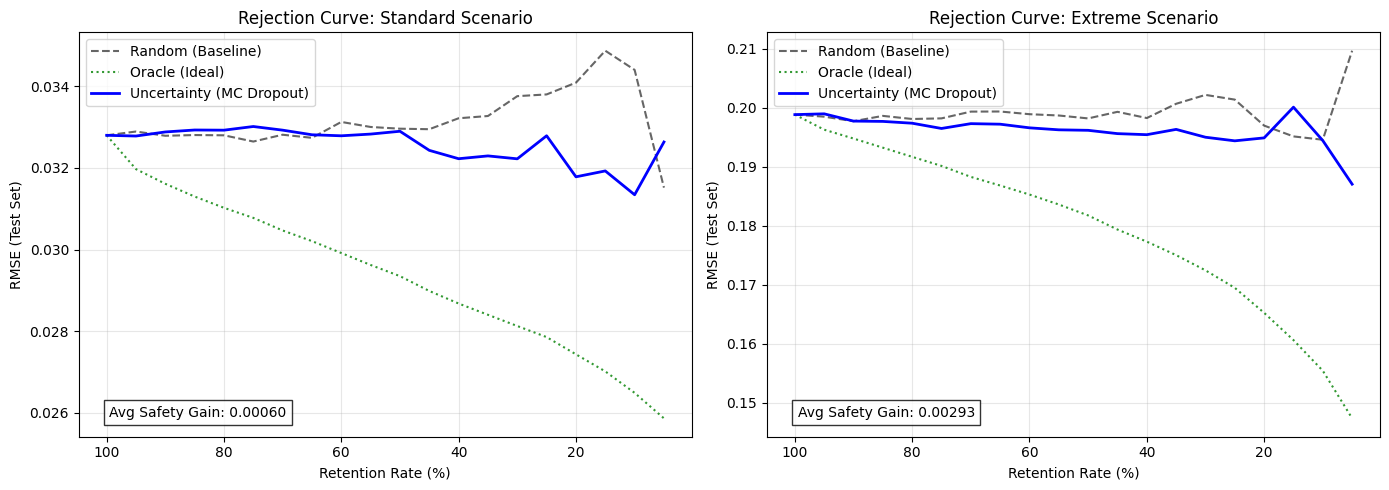

✅ Rejection Analysis Complete.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

def compute_rejection_curves(mse, uncertainty, steps=20):
    """
    Computes 3 curves:
    1. Uncertainty-based (Proposed)
    2. Random (Baseline)
    3. Oracle (Upper Bound - sorting by actual error)
    """
    n_samples = len(mse)
    mse = np.array(mse)
    uncertainty = np.array(uncertainty)

    # Sort indices
    idx_unc = np.argsort(-uncertainty) # High to Low Uncertainty
    idx_oracle = np.argsort(-mse)      # High to Low Error (Cheating)
    idx_random = np.random.permutation(n_samples) # Random

    metrics = {
        "retention": [],
        "rmse_unc": [],
        "rmse_rand": [],
        "rmse_oracle": []
    }

    for i in range(steps):
        # Retention Rate (1.0 -> 0.0)
        retention = (steps - i) / steps
        n_keep = int(n_samples * retention)

        if n_keep < 1: break

        # 1. Uncertainty Rejection
        # We keep the LAST n_keep samples (Lowest uncertainty)
        indices = idx_unc[n_samples - n_keep : ]
        rmse_unc = np.sqrt(np.mean(mse[indices]))

        # 2. Random Rejection
        indices_rand = idx_random[:n_keep]
        rmse_rand = np.sqrt(np.mean(mse[indices_rand]))

        # 3. Oracle Rejection
        # Keep samples with lowest error
        indices_oracle = idx_oracle[n_samples - n_keep : ]
        rmse_oracle = np.sqrt(np.mean(mse[indices_oracle]))

        metrics["retention"].append(retention * 100) # Percent
        metrics["rmse_unc"].append(rmse_unc)
        metrics["rmse_rand"].append(rmse_rand)
        metrics["rmse_oracle"].append(rmse_oracle)

    return metrics

# --- PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scenarios_to_plot = ["Standard", "Extreme"]

for i, name in enumerate(scenarios_to_plot):
    # Extract data from results dict
    data = results[name]
    mse = data['mse_per_sample'].numpy()
    unc = data['unc_per_sample'].numpy()

    # Compute Curves
    curves = compute_rejection_curves(mse, unc)

    # Plot
    ax = axes[i]
    ax.plot(curves["retention"], curves["rmse_rand"], 'k--', label="Random (Baseline)", alpha=0.6)
    ax.plot(curves["retention"], curves["rmse_oracle"], 'g:', label="Oracle (Ideal)", alpha=0.8)
    ax.plot(curves["retention"], curves["rmse_unc"], 'b-', label="Uncertainty (MC Dropout)", linewidth=2)

    ax.set_title(f"Rejection Curve: {name} Scenario")
    ax.set_xlabel("Retention Rate (%)")
    ax.set_ylabel("RMSE (Test Set)")
    ax.invert_xaxis() # Standard way to plot rejection (100% -> 0%)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Annotation: Area Under Curve (Difference from Random)
    # A simple proxy for "Safety Gain"
    gain = np.mean(np.array(curves["rmse_rand"]) - np.array(curves["rmse_unc"]))
    ax.text(0.05, 0.05, f"Avg Safety Gain: {gain:.5f}", transform=ax.transAxes,
            fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Rejection Analysis Complete.")